In [1]:
# ETL Project: Load Products and Categories into SQL Server
# 1. Import Libraries
import pandas as pd
import pyodbc

In [3]:
# 2. Extract: Read CSV files
products_df = pd.read_csv('products.csv')
categories_df = pd.read_csv('categories.csv')

print("Products Data:")
print(products_df)

print("\nCategories Data:")
print(categories_df)

Products Data:
   product_id product_name  price  category_id
0           1       Laptop   1200            1
1           2     Keyboard    100            2
2           3        Mouse     50            2
3           4      Monitor    300            1
4           5         Desk    250            3

Categories Data:
   category_id category_name
0            1   Electronics
1            2   Accessories
2            3     Furniture


In [5]:
# 3. Transform: Data Cleaning / Business Rules
# - Increase price by 10%
products_df['price'] = products_df['price'] * 1.10

# - Merge products with categories (optional for later use)
merged_df = pd.merge(products_df, categories_df, on='category_id', how='left')

print("\nMerged Data:")
print(merged_df)


Merged Data:
   product_id product_name   price  category_id category_name
0           1       Laptop  1320.0            1   Electronics
1           2     Keyboard   110.0            2   Accessories
2           3        Mouse    55.0            2   Accessories
3           4      Monitor   330.0            1   Electronics
4           5         Desk   275.0            3     Furniture


In [9]:
# 4. Connect to SQL Server
conn = pyodbc.connect(
    'Driver={SQL Server};'
    'Server=LAPTOP-23T0BMCL\\SQLEXPRESS;'
    'Database=ETL_Project;'
    'Trusted_Connection=yes;'
)
cursor = conn.cursor()

In [11]:
# 5. Create Tables (if not exist)

# Create categories table
create_categories_query = """
IF OBJECT_ID('categories', 'U') IS NULL
BEGIN
    CREATE TABLE categories (
        category_id INT PRIMARY KEY,
        category_name NVARCHAR(100)
    )
END
"""
cursor.execute(create_categories_query)
conn.commit()

In [13]:
# Create products table

create_products_query = """
IF OBJECT_ID('products', 'U') IS NULL
BEGIN
    CREATE TABLE products (
        product_id INT PRIMARY KEY,
        product_name NVARCHAR(100),
        price FLOAT,
        category_id INT FOREIGN KEY REFERENCES categories(category_id)
    )
END
"""
cursor.execute(create_products_query)
conn.commit()

In [15]:
# 6. Load: Insert Data

# Insert categories
for index, row in categories_df.iterrows():
    cursor.execute(
        "IF NOT EXISTS (SELECT 1 FROM categories WHERE category_id = ?) "
        "INSERT INTO categories (category_id, category_name) VALUES (?, ?)",
        int(row['category_id']),
        int(row['category_id']),
        row['category_name']
    )
conn.commit()

In [17]:
# Insert products
for index, row in products_df.iterrows():
    cursor.execute(
        "IF NOT EXISTS (SELECT 1 FROM products WHERE product_id = ?) "
        "INSERT INTO products (product_id, product_name, price, category_id) VALUES (?, ?, ?, ?)",
        int(row['product_id']),
        int(row['product_id']),
        row['product_name'],
        float(row['price']),
        int(row['category_id'])
    )
conn.commit()

In [19]:
# 7. Verify: Read back the data

products_from_db = pd.read_sql("SELECT * FROM products", conn)
categories_from_db = pd.read_sql("SELECT * FROM categories", conn)

print("\nProducts from SQL Server:")
print(products_from_db)

print("\nCategories from SQL Server:")
print(categories_from_db)


Products from SQL Server:
   product_id product_name   price  category_id
0           1       Laptop  1320.0            1
1           2     Keyboard   110.0            2
2           3        Mouse    55.0            2
3           4      Monitor   330.0            1
4           5         Desk   275.0            3

Categories from SQL Server:
   category_id category_name
0            1   Electronics
1            2   Accessories
2            3     Furniture


C:\Users\hp\AppData\Local\Temp\ipykernel_2176\1641064325.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  products_from_db = pd.read_sql("SELECT * FROM products", conn)
C:\Users\hp\AppData\Local\Temp\ipykernel_2176\1641064325.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  categories_from_db = pd.read_sql("SELECT * FROM categories", conn)


In [21]:
# 8. Close connection
cursor.close()
conn.close()

In [23]:
# 9. Visualization: Average Price per Category

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
avg_price_per_category = merged_df.groupby('category_name')['price'].mean().reset_index()

print("\nAverage Price per Category:")
print(avg_price_per_category)


Average Price per Category:
  category_name  price
0   Accessories   82.5
1   Electronics  825.0
2     Furniture  275.0


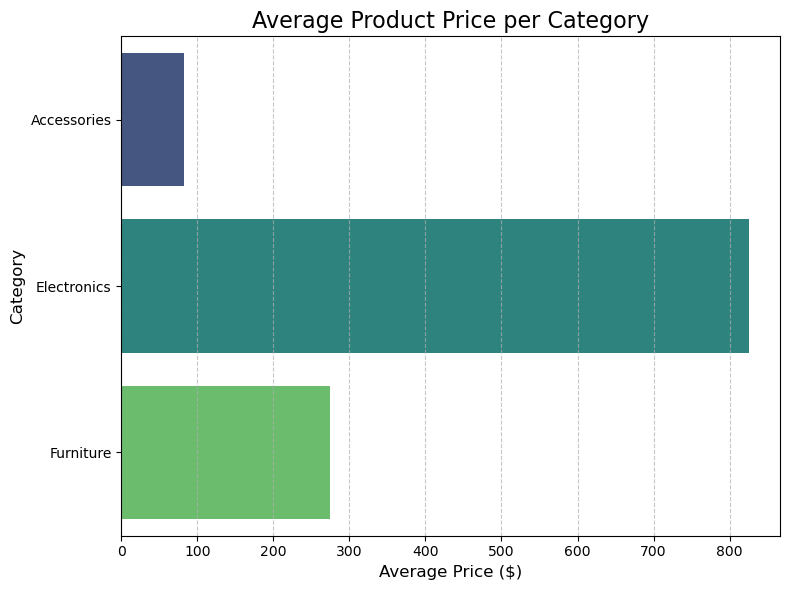

In [27]:
# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x='price',
    y='category_name',
    hue='category_name',
    legend=False,
    data=avg_price_per_category,
    palette='viridis'
)

plt.title('Average Product Price per Category', fontsize=16)
plt.xlabel('Average Price ($)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()